In [ ]:
#!/usr/bin/env Rscript

# -----------------------------
# Parse arguments
# -----------------------------

suppressPackageStartupMessages({
  library(dplyr)
  library(pammtools)
  library(mgcv)
  library(survival)
})


data_path    = '/Users/jkember/Documents/nia_health/NHANES/biological_age/data/output_male/apob/data/data_wide.csv'
duration_col = 'PERMTH_EXM'
event_col    = 'MORTSTAT'
feature      = 'apob'

ped_by       = 1
n_grid       = 100


# --------------------------------
# Reformat data from wide to long.
# --------------------------------
data_wide = read.csv(data_path, stringsAsFactors = FALSE)
data_wide$id = 1:nrow(data_wide)

surv_formula = as.formula(paste0("Surv(", duration_col, ", ", event_col, ") ~ ", feature, " + age"))

data_long = as_ped(
  data_wide,
  formula = surv_formula,
  cut = seq(0, max(data_wide[[duration_col]], na.rm = TRUE), by = ped_by)
)

# --------------------------------
# Generate a prediction grid.
# --------------------------------

# Vary feature values.
feature_values = seq(
  min(data_wide[[feature]], na.rm = TRUE),
  max(data_wide[[feature]], na.rm = TRUE),
  length.out = n_grid
)

# Vary time-horizon values.
tend_values = seq(0, max(data_wide[[duration_col]], na.rm=TRUE), length.out=n_grid)

# Create prediction grid (age set to mean value; has no effect on cumulative hazard ratio).
newdata = expand.grid(tend=tend_values, feature=feature_values, age=mean(data_long$age, na.rm=TRUE))
colnames(newdata)[colnames(newdata) == "feature"] = feature


# --------------------------------
# Fit model
# --------------------------------

model_formula = as.formula(paste("ped_status ~ te(tend, ", feature, ", bs=\"ps\") + age"))

model_pam = gam(
  formula = model_formula,
  data    = data_long,
  family  = poisson(),
  method='REML',
  offset  = data_long$offset,
  gamma=2
)


pred      = predict(model_pam, newdata=newdata, type = "link", se.fit = TRUE)

eta    <- pred$fit
eta_se <- pred$se.fit

hazard      <- exp(eta)
hazard_low  <- exp(eta - 1.96 * eta_se)
hazard_high <- exp(eta + 1.96 * eta_se)

hazard_mat      <- matrix(hazard,      nrow = n_grid, ncol = n_grid, byrow = TRUE)
hazard_low_mat  <- matrix(hazard_low,  nrow = n_grid, ncol = n_grid, byrow = TRUE)
hazard_high_mat <- matrix(hazard_high, nrow = n_grid, ncol = n_grid, byrow = TRUE)

dt <- diff(c(0, tend_values))

cumhaz      <- t(apply(hazard_mat,      1, function(x) cumsum(x * dt)))
cumhaz_low  <- t(apply(hazard_low_mat,  1, function(x) cumsum(x * dt)))
cumhaz_high <- t(apply(hazard_high_mat, 1, function(x) cumsum(x * dt)))

cumhaz_max      <- cumhaz[, n_grid]
cumhaz_max_low  <- cumhaz_low[, n_grid]
cumhaz_max_high <- cumhaz_high[, n_grid]


reference_val <- mean(data_long[[feature]], na.rm = TRUE)
reference_idx <- which.min(abs(feature_values - reference_val))

baseline      <- cumhaz_max[reference_idx]
baseline_low  <- cumhaz_max_low[reference_idx]
baseline_high <- cumhaz_max_high[reference_idx]

HR      <- cumhaz_max      / baseline
HR_low  <- cumhaz_max_low  / baseline_high   # conservative lower
HR_high <- cumhaz_max_high / baseline_low    # conservative upper


# hazard    = matrix(pred$fit, nrow=n_grid, ncol=n_grid, byrow=TRUE)
# hazard_SE = matrix(pred$se.fit, nrow = n_grid, ncol = n_grid, byrow = TRUE)


# # Compute cumulative hazard over time
# dt        = diff(c(0, tend_values))  # time steps
# cumhaz    = t(apply(hazard, 1, function(x) cumsum(x * dt)))
# cumhaz_SE = t(apply(hazard_SE, 1, function(x) sqrt(cumsum((x * dt)^2))))


# # Select final follow-up and reference
# hazard_max_follow_up = cumhaz[, ncol(cumhaz)]
# hazard_max_SE = cumhaz_SE[, ncol(cumhaz_SE)]

# reference_value = mean(data_long[[feature]], na.rm = TRUE)
# reference_idx = which.min(abs(feature_values - reference_value))

# baseline = hazard_max_follow_up[reference_idx]
# baseline_SE = hazard_max_SE[reference_idx]

# # Hazard ratio and 95% CI
# HR = hazard_max_follow_up / baseline
# HR_SE = hazard_max_SE / baseline

# HR_lower = HR * exp(-1.96 * HR_SE / HR)
# HR_upper = HR * exp(1.96 * HR_SE / HR)


In [28]:
HR_high

[1] 1.790912 1.781649 1.772584 1.763717 1.755048 1.746576 1.738302 1.730226
  [9] 1.722350 1.714673 1.707199 1.699928 1.692863 1.686005 1.679359 1.672927
 [17] 1.666713 1.660720 1.654955 1.649422 1.644127 1.639076 1.634276 1.629737
 [25] 1.625465 1.621470 1.617763 1.614355 1.611257 1.608484 1.606048 1.603966
 [33] 1.602252 1.600926 1.600004 1.599507 1.599456 1.599872 1.600778 1.602197
 [41] 1.604154 1.606675 1.609784 1.613508 1.617873 1.622904 1.628628 1.635067
 [49] 1.642247 1.650189 1.658914 1.668440 1.678786 1.689964 1.701988 1.714867
 [57] 1.728609 1.743220 1.758701 1.775055 1.792281 1.810376 1.829339 1.849165
 [65] 1.869850 1.891388 1.913776 1.937008 1.961081 1.985989 2.011731 2.038304
 [73] 2.065706 2.093935 2.122993 2.152880 2.183597 2.215148 2.247537 2.280767
 [81] 2.314845 2.349776 2.385569 2.422231 2.459771 2.498198 2.537524 2.577759
 [89] 2.618916 2.661007 2.704046 2.748046 2.793024 2.838993 2.885972 2.933976
 [97] 2.983023 3.033131 3.084320 3.136609

In [22]:
HR_df = data.frame(feature_value=feature_values, HR=HR, HR_lower=HR_lower, HR_upper=HR_upper)
write.csv(HR_df, file=file.path("hazard_ratio_vectors.csv"), row.names=FALSE)


In [20]:
# save_array <- function(mat, rows, cols, file) {
#   rownames(mat) <- round(rows, 3)
#   colnames(mat) <- round(cols, 2)
#   write.csv(as.data.frame(mat), file, row.names=TRUE, quote=FALSE)
# }

# save_vector <- function(mat, rows, file) {
#   rownames(mat) <- round(rows, 3)
#   write.csv(as.data.frame(mat), file, row.names=TRUE, quote=FALSE)
# }

# save_vector(HR_upper, feature_values, file.path("hazard_ratio_upper_CI-vector"))


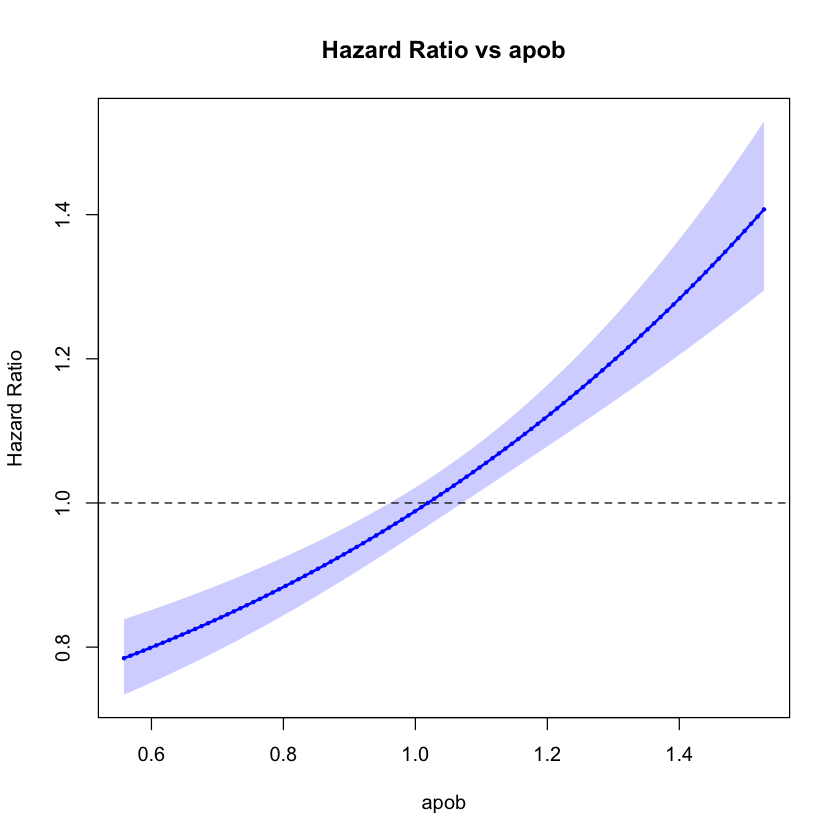

In [121]:
# predict with se.fit = TRUE
pred = predict(model_pam, newdata=newdata, type="response", se.fit=TRUE)

# hazard and SE matrices
hazard    = matrix(pred$fit, nrow=n_grid, ncol=n_grid, byrow=TRUE)
hazard_SE = matrix(pred$se.fit, nrow=n_grid, ncol=n_grid, byrow=TRUE)

# time step
dt = diff(c(0, tend_values))

# cumulative hazard
cumhaz    = t(apply(hazard, 1, function(x) cumsum(x * dt)))
cumhaz_SE = t(apply(hazard_SE, 1, function(x) sqrt(cumsum((x * dt)^2))))


# select max follow-up (last column)
hazard_max_follow_up = cumhaz[, ncol(cumhaz)]
hazard_SE_max        = cumhaz_SE[, ncol(cumhaz_SE)]


# Reference index: closest to mean
reference_value = mean(data_long[[feature]], na.rm = TRUE)
reference_idx   = which.min(abs(feature_values - reference_value))

# Hazard ratio
HR = hazard_max_follow_up / hazard_max_follow_up[reference_idx]

# Delta-method SE on log scale
SE_logHR = hazard_SE_max / hazard_max_follow_up

# 95% CI
HR_lower = HR * exp(-1.96 * SE_logHR)
HR_upper = HR * exp(1.96 * SE_logHR)


# Plot
plot(feature_values, HR, type="l", lwd=2, col="blue",
     ylim = c(min(HR_lower), max(HR_upper)),
     xlab = feature, ylab = "Hazard Ratio",
     main = paste("Hazard Ratio vs", feature))

polygon(c(feature_values, rev(feature_values)),
        c(HR_lower, rev(HR_upper)),
        col = rgb(0,0,1, alpha=0.2), border=NA)

abline(h=1, lty=2, col="black")
points(feature_values, HR, type="p", pch=16, cex=0.5, col="blue")


In [126]:
exp(SE_logHR)

[1] 1.034598 1.034137 1.033677 1.033216 1.032755 1.032295 1.031834 1.031374
  [9] 1.030915 1.030455 1.029997 1.029538 1.029081 1.028625 1.028169 1.027715
 [17] 1.027262 1.026811 1.026362 1.025915 1.025470 1.025028 1.024590 1.024154
 [25] 1.023723 1.023296 1.022874 1.022457 1.022046 1.021641 1.021244 1.020855
 [33] 1.020474 1.020103 1.019742 1.019393 1.019055 1.018732 1.018423 1.018129
 [41] 1.017853 1.017594 1.017355 1.017137 1.016941 1.016768 1.016619 1.016497
 [49] 1.016401 1.016334 1.016295 1.016286 1.016308 1.016360 1.016444 1.016559
 [57] 1.016706 1.016884 1.017093 1.017332 1.017601 1.017900 1.018227 1.018582
 [65] 1.018963 1.019371 1.019803 1.020259 1.020739 1.021240 1.021763 1.022306
 [73] 1.022869 1.023450 1.024049 1.024666 1.025299 1.025948 1.026613 1.027292
 [81] 1.027985 1.028693 1.029413 1.030147 1.030893 1.031651 1.032421 1.033203
 [89] 1.033996 1.034799 1.035613 1.036438 1.037273 1.038118 1.038973 1.039837
 [97] 1.040711 1.041595 1.042487 1.043388

In [75]:
# library(mgcv)
# library(dplyr)
# library(ggplot2)



# # Parameters
# feature        = "apob"
# n_grid         = 100
# tend_values    = seq(min(data_long$tend), max(data_long$tend), length.out=n_grid)
# feature_values = seq(min(data_long[[feature]]), max(data_long[[feature]]), length.out=n_grid)
# age_val        = median(data_long$age)


# newdata = expand.grid(tend=tend_values, feature=feature_values, age=age_val)
# names(newdata)[names(newdata) == "feature"] <- feature


# pred      = predict(model_pam, newdata=newdata, type = "response", se.fit = TRUE)
# hazard    = matrix(pred$fit, nrow=n_grid, ncol=n_grid, byrow=TRUE)
# hazard_SE = matrix(pred$se.fit, nrow = n_grid, ncol = n_grid, byrow = TRUE)


# # Compute cumulative hazard over time
# dt        = diff(c(0, tend_values))  # time steps
# cumhaz    = t(apply(hazard, 1, function(x) cumsum(x * dt)))
# cumhaz_SE = t(apply(hazard_SE, 1, function(x) sqrt(cumsum((x * dt)^2))))


# # Select final follow-up and reference
# hazard_max_follow_up = cumhaz[, ncol(cumhaz)]
# hazard_max_SE = cumhaz_SE[, ncol(cumhaz_SE)]

# reference_value = mean(data_long[[feature]], na.rm = TRUE)
# reference_idx = which.min(abs(feature_values - reference_value))

# baseline = hazard_max_follow_up[reference_idx]
# baseline_SE = hazard_max_SE[reference_idx]

# # Hazard ratio and 95% CI
# HR = hazard_max_follow_up / baseline
# HR_SE = hazard_max_SE / baseline

# HR_lower = HR * exp(-1.96 * HR_SE / HR)
# HR_upper = HR * exp(1.96 * HR_SE / HR)


In [4]:

# ggplot(df_plot, aes(x = feature_value, y = HR)) +
#   geom_line(color = "blue", size = 1) +
#   geom_ribbon(aes(ymin = HR_lower, ymax = HR_upper), fill = "blue", alpha = 0.2) +
#   geom_hline(yintercept = 1, linetype = "dashed") +
#   xlab(feature) +
#   ylab("Cumulative Hazard Ratio") +
#   ggtitle(paste0("Cumulative HR ± 95% CI at max follow-up (reference = mean ", round(reference_value,2), ")")) +
#   theme_minimal()

In [69]:
newdata = expand.grid(tend=tend_values, age=age_val)
newdata[[feature]] = rep(feature_values, each=n_grid)


ERROR: Error in `[[<-.data.frame`(`*tmp*`, feature, value = c(0.558386505610872, : replacement has 10000 rows, data has 100


In [67]:
newdata

tend,age
<dbl>,<dbl>
1.000000,41.08333
1.303030,41.08333
1.606061,41.08333
1.909091,41.08333
2.212121,41.08333
2.515152,41.08333
2.818182,41.08333
3.121212,41.08333
3.424242,41.08333
